In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from collections import namedtuple
from datetime import date, timedelta

from algo.sde.ornstein_uhlenbeck_optimisation import calc_optimal_ou_params, log_likelihood_ou, ou_bet_size_loglikelihoods, ou_hedging_parameters
from etl.yfinance_data import get_pairs_data


sns.set_style("darkgrid")

In [28]:
interval = "1h"
# interval = "1d"
interval_map = {
    "1m": timedelta(minutes=60*24*7),
    "1h": timedelta(hours=24*90),
    "1d": timedelta(days=365*1),   
}
test_size_map = {
    "1m": int(60*2),
    "1h": int(24*7),  # Good - 1 week horizon.
    "1d": 30,   
}

num_test = test_size_map[interval]

# Let one unit of time be equivalent to one step in the data. TODO: later - clean data to rm. discontinuities (weekends etc.).
dt = 1

ticker1 = "BZ=F"
ticker2 = "CL=F"

today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = (today - interval_map[interval]).strftime("%Y-%m-%d")
df_full = get_pairs_data(ticker1, ticker2, start_date, end_date, interval)

print(f"\nDates Requested: {start_date} to {end_date}")
print(f"Dates Received: {df_full.index[0]} to {df_full.index[-1]}\n")

df_full.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Dates Requested: 2022-08-25 to 2022-11-23
Dates Received: 2022-08-24 19:00:00-04:00 to 2022-11-22 18:00:00-05:00



,S1,S2
2022-11-22 13:00:00-05:00,88.620003,81.180000
2022-11-22 14:00:00-05:00,88.510002,81.120003
2022-11-22 15:00:00-05:00,88.489998,81.209999
2022-11-22 16:00:00-05:00,88.440002,81.099998
2022-11-22 18:00:00-05:00,88.650002,81.300003


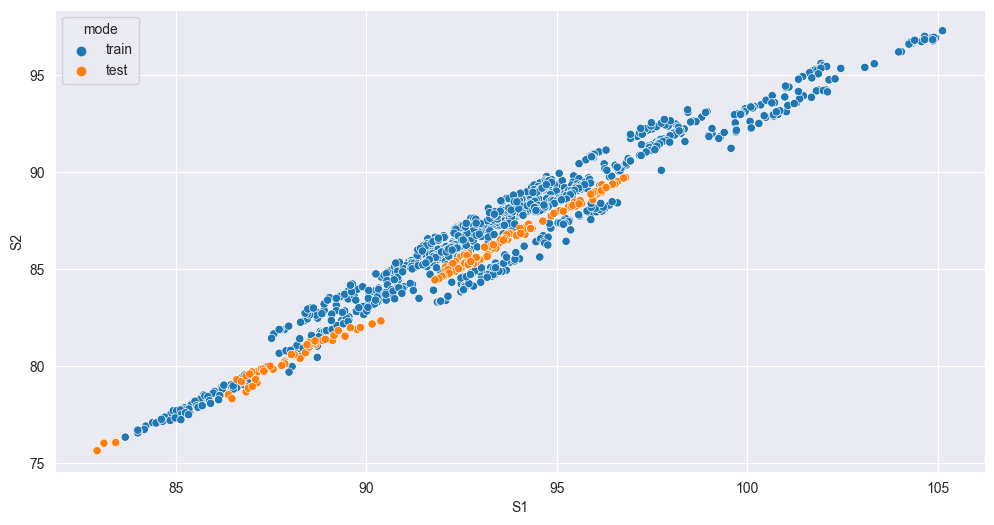

In [29]:
df_full["mode"] = "train"
df_full.loc[df_full.index[-num_test:], "mode"] = "test"

# Assess linearity
sns.scatterplot(data=df_full, x="S1", y="S2", hue="mode")
plt.show()

In [30]:
num_train = len(df_full) - num_test

df = df_full.head(num_train).copy()
df_test = df_full.tail(num_test).copy()

len(df), len(df_test)

(1091, 168)

In [31]:
# Test correlation: require < 1.
df_prices = df[["S1", "S2"]]
corr = df_prices.corr().stack()
corr[corr < 1]

S1  S2    0.973957
S2  S1    0.973957
dtype: float64

In [32]:
# start = 0.001
# end = 1.0
# num = int(1/start)
# B_candidates = np.linspace(start, end, num)

# A = 1.0
# alpha = A / df["S1"].iloc[0]
# log_likelihoods, ou_params_candidates, halflives = ou_bet_size_loglikelihoods(df["S1"], df["S2"], dt, alpha, B_candidates)
# hp_ll_opt, hp_mu_opt = ou_hedging_parameters(log_likelihoods, ou_params_candidates, B_candidates, S2_0=df["S2"].iloc[0], A=A, alpha=alpha)

# hp = hp_ll_opt
# ll = hp["log_likelihood"]
# ou_params = hp["ou_params"]
# alpha = hp["alpha"]
# beta = hp["beta"]
# A = hp["A"]
# B = hp["B"]

# alpha, beta, A, B

# Raw price series
series1 = df["S1"]
series2 = df["S2"]

# Simple returns series
# series1 = df["S1_returns"]
# series2 = df["S2_returns"]

start = 0.001
end = 1.0
num = int(1/start)
B_candidates = np.linspace(start, end, num)

A = 1.0
alpha = A / series1.iloc[0]
log_likelihoods, ou_params_candidates, halflives = ou_bet_size_loglikelihoods(series1, series2, dt, alpha, B_candidates)
hp_ll_opt, hp_mu_opt = ou_hedging_parameters(log_likelihoods, ou_params_candidates, B_candidates, S2_0=series2.iloc[0], A=A, alpha=alpha)

hp = hp_ll_opt
ll = hp["log_likelihood"]
ou_params = hp["ou_params"]
alpha = hp["alpha"]
beta = hp["beta"]
A = hp["A"]
B = hp["B"]

alpha, beta, A, B

(0.009831875027050933, 0.008727158048169828, 1.0, 0.8310000000000001)

# Cointegration Tests

TODO: make `pre-trade analytics` pre-flight checks and sit out the market if failed for a period of time until passed.

In [34]:
from statsmodels.tsa.stattools import adfuller
from algo.cointegration.augmented_dickey_fuller import print_adf_results

In [35]:
# Check for stationarity in the raw assets. We do not want this.
p_value = 0.05

adf_S1 = adfuller(df["S1"], regression="ct")
adf_S2 = adfuller(df["S2"], regression="ct")

_msg = f"Stationarity detected in raw asset time series, at p-value = {p_value}"
assert adf_S1[1] > p_value, _msg
assert adf_S2[1] > p_value, _msg

In [36]:
# Training set
df["spread"] = alpha*df["S1"] - beta*df["S2"]

# adf_spread = adfuller(df["spread"], maxlag=1)
adf_spread = adfuller(df["spread"], regression="ct")
print_adf_results(adf_spread)

Failed to reject the null hypothesis - no cointegration.


In [37]:
# Test set, under hedging parameters calibrated on the training set
df_test["spread"] = alpha*df_test["S1"] - beta*df_test["S2"]

# adf_spread_test = adfuller(df_test["spread"], maxlag=1)
adf_spread_test = adfuller(df_test["spread"], regression="ct")
print_adf_results(adf_spread_test)

REJECT the null hypothesis of a unit root in the residuals at the 5% significance level. S1 and S2 are cointegrated.


In [39]:
# Require stationarity in the constructed spread time series
adf_spread[1] < p_value, adf_spread_test[1] < p_value

(False, True)

In [40]:
# Johansen Test
critical_values = {
    0: {0.9: 13.4294, 0.95: 15.4943, 0.99: 19.9349},  # Critical values for 0 cointegration relationships.
    1: {0.9: 2.7055, 0.95: 3.8415, 0.99: 6.6349},     # Critical values for 1 cointegration relationship.
}

trace0_cv_95 = critical_values[0][0.95]
trace1_cv_95 = critical_values[1][0.95]

In [41]:
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

In [42]:
df_prices = df[["S1", "S2"]]

# Vector Autoregressive Model
var = VAR(df_prices.values)
lags = var.select_order()
k_ar_diff = lags.selected_orders["aic"]

cj = coint_johansen(df_prices, det_order=0, k_ar_diff=k_ar_diff)

# lr1 := Trace Statistic
trace0, trace1 = cj.lr1

# Did we pass the Johansen Test? - Require: (True, True).
trace0 > trace0_cv_95, trace1 > trace1_cv_95

(False, True)

In [43]:
# Augmented Engle-Granger two-step cointegration test. Test in both directions.
coint_t_stat_1, p_value_1 = coint(df["S1"], df["S2"], trend="c")[:2]
coint_t_stat_2, p_value_2 = coint(df["S2"], df["S1"], trend="c")[:2]

# Did we pass the Engle-Granger Test? - Require: (True, True).
p_value_1 < p_value, p_value_2 < p_value

(False, False)

# SDE - OU

In [44]:
from algo.sde.ornstein_uhlenbeck_optimisation import estimate_halflife_ou


spread = df["spread"]
estimate_halflife_ou(spread)

36.15876767108822

In [45]:
# Test against own OU simulation
from algo.sde.ornstein_uhlenbeck import OrnsteinUhlenbeck


x = df["spread"].to_numpy()

# Test the process by running through an OU Model.
ou_model = OrnsteinUhlenbeck(X_0=x[0], theta=ou_params.theta, k=ou_params.mu, sigma=ou_params.sigma)
ou_process_simulated = ou_model(num_samples=len(x))
df["X_t-sim"] = ou_process_simulated


# Test against library simulation
import sdepy

ou_lib = sdepy.ornstein_uhlenbeck_process(x0=x[0], theta=ou_params.theta, k=ou_params.mu, sigma=ou_params.sigma)
df["X_t-sdepy"] = ou_lib(np.linspace(1, len(df), len(df)))

In [46]:
ou_params_sim = calc_optimal_ou_params(ou_process_simulated, dt)
ll_sim = log_likelihood_ou(theta=ou_params_sim.theta, mu=ou_params_sim.mu, sigma_sq=ou_params_sim.sigma_sq, x=ou_process_simulated, dt=dt)


def sim_results(ll, ll_sim, ou_params, ou_params_sim):
    # Want these differences to be as small as possible
    df_summary = pd.DataFrame(columns=["Real Data", "Sim", "% Diff"])
    df_summary["Real Data"] = [ou_params.theta, ou_params.mu, ou_params.sigma, ll]
    df_summary["Sim"] = [ou_params_sim.theta, ou_params_sim.mu, ou_params_sim.sigma, ll_sim]
    df_summary["% Diff"] = 100.0 * (df_summary["Real Data"] - df_summary["Sim"]) / df_summary["Real Data"]
    df_summary.index = ["theta", "mu", "sigma", "log_li"]
    
    return df_summary


df_summary = sim_results(ll, ll_sim, ou_params, ou_params_sim)
df_summary.round(3)

,Real Data,Sim,% Diff
theta,0.160,0.154,3.527
mu,0.015,0.009,38.085
sigma,0.002,0.002,3.493
log_li,4.936,4.968,-0.652


Text(0, 0.5, 'Log-Likelihood')

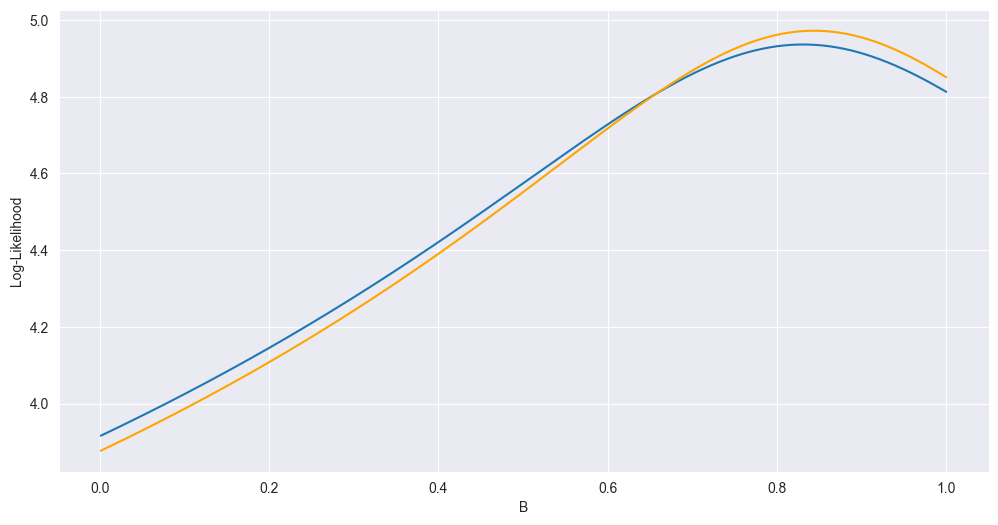

In [47]:
# Compare long-run mean in train set vs. full set (train+test).
# alpha_full = A / df_full["S1"].iloc[0]
# log_likelihoods_full, ou_params_candidates_full, _ = ou_bet_size_loglikelihoods(df_full["S1"], df_full["S2"], dt, alpha_full, B_candidates)

# plt.plot(B_candidates, log_likelihoods)
# plt.plot(B_candidates, log_likelihoods_full, color="orange")
# plt.xlabel("B")
# plt.ylabel("Log-Likelihood")

series1 = df_full["S1"]
series2 = df_full["S2"]


alpha_full = A / series1.iloc[0]
log_likelihoods_full, ou_params_candidates_full, _ = ou_bet_size_loglikelihoods(series1, series2, dt, alpha_full, B_candidates)

plt.plot(B_candidates, log_likelihoods)
plt.plot(B_candidates, log_likelihoods_full, color="orange")
plt.xlabel("B")
plt.ylabel("Log-Likelihood")

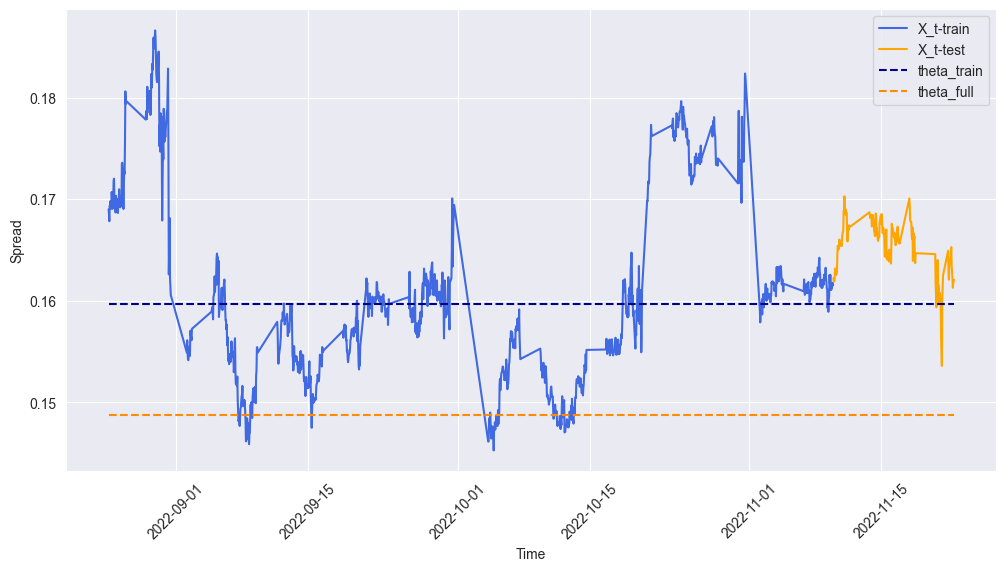

In [48]:
hp_full, _ = ou_hedging_parameters(log_likelihoods_full, ou_params_candidates_full, B_candidates, S2_0=df["S2"].iloc[0], A=A, alpha=alpha)
theta_full = hp_full["ou_params"].theta


plt.plot(df.index, df["spread"], color="royalblue", label="X_t-train")
plt.plot(df_test.index, df_test["spread"], color="orange", label="X_t-test")
plt.hlines(ou_params.theta, xmin=df.index[0], xmax=df_test.index[-1], color="darkblue", linestyle="dashed", label="theta_train")
plt.hlines(theta_full, xmin=df.index[0], xmax=df_test.index[-1], color="darkorange", linestyle="dashed", label="theta_full")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Spread")
plt.xticks(rotation=45)
plt.show()

# Z-score analysis

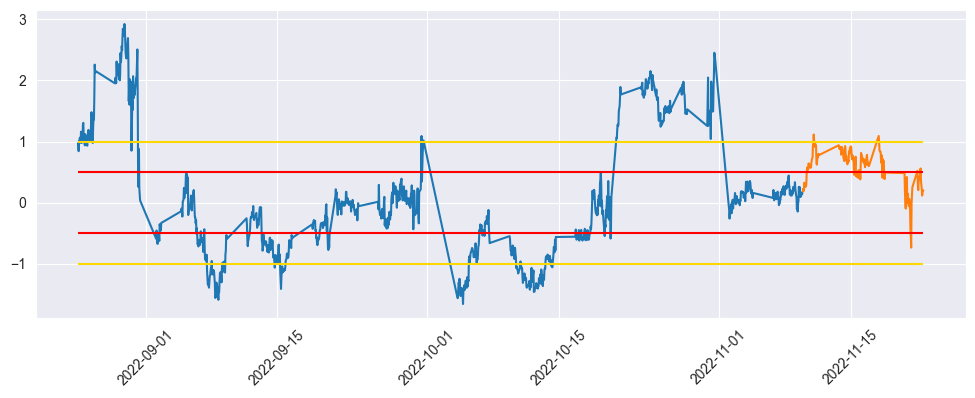

In [49]:
def zscore(x, mean, std_dev):
    """
    Args:
        x: 
        mean: E[x], or a lagged value thereof.
        std_dev: sqrt(Var[x]), or a lagged value thereof.
    """
    return (x - mean) / std_dev
    

def zscore_signals(df_in, z_entry_threshold, z_exit_threshold):
    """
    Args:
        x:
        z_entry_threshold: when to long the portfolio, i.e. enter market.
        z_exit_threshold: when to short the portfolio, i.e. exit market.
    
    Returns:
    
    """
    df = df_in.copy()

    # Cast bools -> floats
    df["long"] = 1.0*(df["zscore"] <= -z_entry_threshold)
    df["short"] = 1.0*(df["zscore"] >= z_entry_threshold)
    df["exit"] = 1.0*(np.abs(df["zscore"]) <= z_exit_threshold)
    
    return df


z_entry_threshold = 1.0
z_exit_threshold = 0.5

# Calibrate using only training set.
df["zscore"] = zscore(x=df["spread"], mean=df["spread"].mean(), std_dev=df["spread"].std())
df = df.pipe(zscore_signals, z_entry_threshold=z_entry_threshold, z_exit_threshold=z_exit_threshold)

# Test using the mean and std_dev of the training set.
df_test["zscore"] = zscore(x=df_test["spread"], mean=df["spread"].mean(), std_dev=df["spread"].std())
df_test = df_test.pipe(zscore_signals, z_entry_threshold=z_entry_threshold, z_exit_threshold=z_exit_threshold)


plt.figure(figsize=(12,4))
plt.plot(df.index, df["zscore"])
plt.plot(df_test.index, df_test["zscore"])
plt.hlines(
    [z_entry_threshold, -z_entry_threshold, z_exit_threshold, -z_exit_threshold],
    colors=["gold", "gold", "red", "red"],
    xmin=df.index[0],
    xmax=df_test.index[-1],
)
plt.xticks(rotation=45)
plt.show()

In [50]:
def compute_positions(df_in):
    df = df_in.copy()
    
    # Signals to demonstrate when to propagate positions forward:
    # - Stay long if: Z_exit_threshold < Z < Z_entry_threshold
    # - Stay short if: Z_entry_threshold < Z < Z_exit_threshold
    df["long_market"] = 0.0  # Must be float
    df["short_market"] = 0.0  # Must be float

    # Track whether to be long or short while iterating through each timestep
    long_market = 0.0  # Must be float
    short_market = 0.0  # Must be float

    # Calculate when to be in the market via holding a long or short position, and when to exit the market.
    # Hard to vectorise: note how `long_market` and `short_market` values are carried over in each loop iteration.
    long_markets = []
    short_markets = []
    for i, row in enumerate(df.iterrows()):
        if row[1]["long"] == 1.0:
            long_market = 1            
        if row[1]["short"] == 1.0:
            short_market = 1
        if row[1]["exit"] == 1.0:
            long_market = 0
            short_market = 0

        # Assign 1/0 to long_market/short_market to indicate when to stay in a position
        long_markets.append(long_market)
        short_markets.append(short_market)

    df["long_market"] = long_markets 
    df["short_market"] = short_markets
    df["positions"] = df["long_market"] - df["short_market"]

    # Using _pos to distinguish portfolio from raw.
    df["S1_pos"] = -1.0 * df["S1"] * df["positions"]
    df["S2_pos"] = df["S2"] * df["positions"]
    df["total"] = df["S1_pos"] + df["S2_pos"]

    return df


df = df.pipe(compute_positions)
df_test = df_test.pipe(compute_positions)

In [51]:
# Naming convention: `returns := simple returns, returns_cml := cumulative returns`

# TODO: S1_pos, S2_pos - made distinction to preserve data. Careful to propagate.

def compute_returns(df_in):
    df = df_in.copy()
    
    # Calculate simple percentage returns
    df["returns_pc"] = df["total"].pct_change()

    df["returns_pc"].fillna(0.0, inplace=True)
    df["returns_pc"].replace([np.inf, -np.inf], 0.0, inplace=True)
    df["returns_pc"].replace(-1.0, 0.0, inplace=True)

    # Accumulate returns across each time period
    df["returns_cml"] = (1.0 + df["returns_pc"]).cumprod()

    # S1 and S2 correct here: comparing PF to buy-and-hold.
    df["returns_cml_S1"] = (df["S1"].pct_change()+1.0).cumprod()
    df["returns_cml_S2"] = (df["S2"].pct_change()+1.0).cumprod()

    return df

df = df.pipe(compute_returns)
df_test = df_test.pipe(compute_returns)

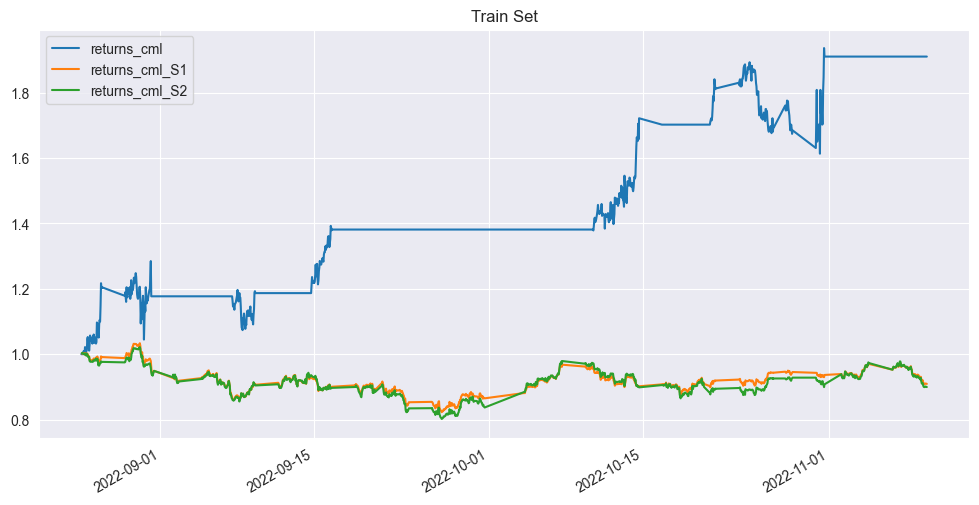

In [52]:
df[["returns_cml", "returns_cml_S1", "returns_cml_S2"]].plot()
plt.title("Train Set")
plt.show()

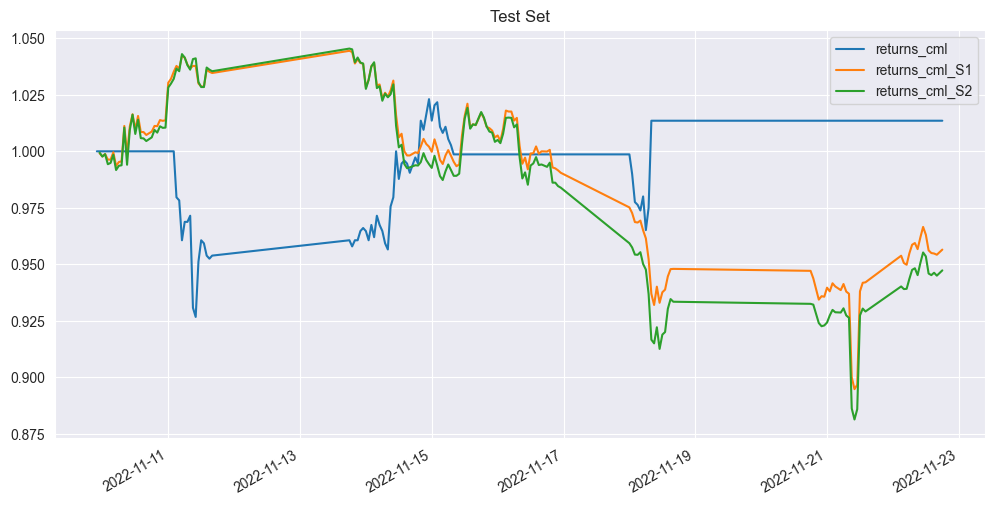

In [53]:
df_test[["returns_cml", "returns_cml_S1", "returns_cml_S2"]].plot()
plt.title("Test Set")
plt.show()

In [54]:
def sharpe_ratio_simple(df, colname="returns_pc"):
    sharpe = df[colname].mean() / df[colname].std()
    return sharpe
    
# sharpe_ratio = sharpe_ratio_simple(df)
# sharpe_ratio_test = sharpe_ratio_simp(df_test)


def sharpe_ratio_log(df, colname="total"):
    # Log returns are additive - better choice when doing *sqrt(252)
    log_returns = np.log(df[colname]/df[colname].shift())
    log_returns.fillna(0.0, inplace=True)
    log_returns.replace([np.inf, -np.inf], 0.0, inplace=True)

    sharpe = log_returns.mean()/log_returns.std()
    return sharpe


sharpe_ratio = sharpe_ratio_log(df)
sharpe_ratio_test = sharpe_ratio_log(df_test)


# Annualise: data is hourly. Futures: 23 hours in a trading day, 252 trading days in a year.
# Portfolio returns are a BM -> volatility scales with sqrt(time).
sharpe_ratio_annual = sharpe_ratio*np.sqrt(23*252)
sharpe_ratio_annual_test = sharpe_ratio_test*np.sqrt(23*252)

print(f"Sharpe Annual Train Set = {sharpe_ratio_annual}")
print(f"Sharpe Annual Test  Set = {sharpe_ratio_annual_test}")

Sharpe Annual Train Set = 3.520070476223611
Sharpe Annual Test  Set = 0.8886317448275523


/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
